In [308]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
maxcols = pd.get_option("display.max_columns")
from collections import defaultdict

In [309]:
# para entrenar
X_t0 = pd.read_parquet('X_t0.parquet')
y_t0 = pd.read_parquet('y_t0.parquet')
# para predecir(?)
X_t1 = pd.read_parquet('X_t1.parquet')
X_t0 = X_t0[sorted(X_t0.columns)]
X_t1 = X_t1[sorted(X_t1.columns)]

In [311]:
pd.set_option("display.max_columns", maxcols )
X_t0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44296 entries, 0 to 44295
Data columns (total 77 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   avg_gas_paid_per_tx_eth                  44296 non-null  float64
 1   avg_risk_factor                          44296 non-null  float64
 2   avg_weighted_risk_factor                 44296 non-null  float64
 3   borrow_amount_avg_eth                    44296 non-null  float64
 4   borrow_amount_sum_eth                    44296 non-null  float64
 5   borrow_block_number                      44296 non-null  int64  
 6   borrow_count                             44296 non-null  int64  
 7   borrow_repay_diff_eth                    44296 non-null  float64
 8   borrow_timestamp                         44296 non-null  float64
 9   deposit_amount_sum_eth                   44296 non-null  float64
 10  deposit_count                            44296

In [312]:
numeric_var = X_t0.select_dtypes(include=['number']).columns
object_var = X_t0.select_dtypes(include=['object']).columns

In [324]:
import datetime
timestamps = [col for col in X_t0.columns if "timestamp" in col]
pd.set_option("display.max_columns", None)
X_t0[timestamps].map(lambda ms: datetime.datetime.fromtimestamp(ms))

,borrow_timestamp,first_tx_timestamp,last_tx_timestamp,risky_first_last_tx_timestamp_diff,risky_first_tx_timestamp,risky_last_tx_timestamp
0,2019-05-06 22:48:28,2018-09-17 19:44:19,2019-05-06 22:44:34,1969-12-31 21:00:00,2001-09-08 22:46:39,2001-09-08 22:46:39
1,2019-05-06 22:50:47,2018-09-17 19:44:19,2019-05-06 22:48:28,1969-12-31 21:00:00,2001-09-08 22:46:39,2001-09-08 22:46:39
2,2019-05-06 22:51:37,2018-09-17 19:44:19,2019-05-06 22:50:47,1969-12-31 21:00:00,2001-09-08 22:46:39,2001-09-08 22:46:39
3,2019-05-07 00:55:33,2019-05-06 21:03:31,2019-05-06 22:52:25,1969-12-31 21:00:00,2001-09-08 22:46:39,2001-09-08 22:46:39
4,2019-05-07 04:20:08,2019-05-07 04:15:44,2019-05-07 04:19:14,1969-12-31 21:00:00,2001-09-08 22:46:39,2001-09-08 22:46:39
...,...,...,...,...,...,...
44291,2020-06-25 14:31:12,2020-06-21 22:58:38,2020-06-25 14:30:10,1970-01-04 12:18:53,2020-06-21 23:11:17,2020-06-25 14:30:10
44292,2020-06-25 14:35:36,2020-05-18 12:37:22,2020-06-25 14:33:23,1970-01-12 08:54:42,2020-06-13 03:01:05,2020-06-24 14:55:47
44293,2020-06-25 14:36:45,2019-09-12 15:17:02,2020-06-25 14:35:02,1970-01-09 16:54:35,2020-06-16 18:36:31,2020-06-25 14:31:06
44294,2020-06-25 14:37:14,2019-06-27 14:01:46,2020-06-25 14:26:06,1970-01-01 19:08:15,2020-06-23 21:26:11,2020-06-24 19:34:26


In [331]:
vars = object_var.insert(len(object_var), 'risky_first_tx_timestamp')
vars

Index(['wallet_address', 'risky_first_tx_timestamp'], dtype='object')

In [338]:
for _ ,df in X_t0[vars].groupby(*object_var):
    print(df)

                                   wallet_address  risky_first_tx_timestamp
35145  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
35165  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
36706  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
37100  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
37739  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
37746  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
37766  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
37769  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
38073  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
42038  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
42251  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
42253  0x0000000484f2217f1a64eb6d24b5cee446faeae5                1592253644
42315  0x000

In [313]:
# Busca las variables binarias a partir del número de valores distintos que tenga
weird = defaultdict(list)
threshold = 0.7
for col in X_t0[numeric_var]:
    diff_values = len(X_t0[col].value_counts())
    min_prop = (X_t0[col] == X_t0[col].min()).sum() / len(X_t0[col]) 
    max_prop = (X_t0[col] == X_t0[col].max()).sum() / len(X_t0[col])
    is_binary = diff_values == 2
    is_weird = False
    if min_prop > threshold and not is_binary :
        weird['min_prop'].append(col)
        is_weird = True
    if max_prop > threshold and not is_binary :
        weird['max_prop'].append(col)
        is_weird = True
    if is_binary:
        weird['binary'].append(col)
        is_weird = True
    if not is_weird:
        weird['not'].append(col)
    print(f"{col}:\n # valores distintos: {diff_values}\n Proporción de valor mínimo: {min_prop}\n Proporción de valor máximo: {max_prop};\n\n")

avg_gas_paid_per_tx_eth:
 # valores distintos: 44247
 Proporción de valor mínimo: 0.000428932635000903
 Proporción de valor máximo: 2.257540184215279e-05;


avg_risk_factor:
 # valores distintos: 33887
 Proporción de valor mínimo: 0.1553639154776955
 Proporción de valor máximo: 2.257540184215279e-05;


avg_weighted_risk_factor:
 # valores distintos: 33815
 Proporción de valor mínimo: 0.2322557341520679
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_amount_avg_eth:
 # valores distintos: 35723
 Proporción de valor mínimo: 0.16005959906086328
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_amount_sum_eth:
 # valores distintos: 34824
 Proporción de valor mínimo: 0.16005959906086328
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_block_number:
 # valores distintos: 42584
 Proporción de valor mínimo: 2.257540184215279e-05
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_count:
 # valores distintos: 2466
 Proporción de valor mínimo: 0.153241

In [314]:
for name, keys in weird.items():
    print(f"{name.upper()}:\n {', '.join(sorted(keys))}\n")

NOT:
 avg_gas_paid_per_tx_eth, avg_risk_factor, avg_weighted_risk_factor, borrow_amount_avg_eth, borrow_amount_sum_eth, borrow_block_number, borrow_count, borrow_repay_diff_eth, borrow_timestamp, deposit_amount_sum_eth, deposit_count, first_tx_timestamp, incoming_tx_avg_eth, incoming_tx_count, incoming_tx_sum_eth, last_tx_timestamp, market_adx, market_adxr, market_apo, market_aroonosc, market_aroonup, market_atr, market_cci, market_cmo, market_correl, market_dx, market_fastd, market_fastk, market_linearreg_slope, market_macd, market_macd_macdext, market_macd_macdfix, market_macdsignal, market_macdsignal_macdext, market_macdsignal_macdfix, market_max_drawdown_365d, market_natr, market_plus_di, market_plus_dm, market_ppo, market_rocp, market_rocr, max_eth_ever, max_risk_factor, min_eth_ever, net_incoming_tx_count, outgoing_tx_avg_eth, outgoing_tx_count, outgoing_tx_sum_eth, repay_amount_avg_eth, repay_amount_sum_eth, repay_count, risk_factor, risk_factor_above_threshold_daily_count, time

In [315]:
numeric_var = numeric_var.drop(weird['binary'])

In [316]:
weird['binary']

['market_ht_trendmode',
 'unique_borrow_protocol_count',
 'unique_lending_protocol_count']

In [317]:
weird_list = [col for name, cols in weird.items() for col in cols if name != 'not' or name != 'binary']

In [318]:
pd.set_option("display.max_columns", None)
X_t0[numeric_var].describe()

,avg_gas_paid_per_tx_eth,avg_risk_factor,avg_weighted_risk_factor,borrow_amount_avg_eth,borrow_amount_sum_eth,borrow_block_number,borrow_count,borrow_repay_diff_eth,borrow_timestamp,deposit_amount_sum_eth,deposit_count,first_tx_timestamp,incoming_tx_avg_eth,incoming_tx_count,incoming_tx_sum_eth,last_tx_timestamp,liquidation_amount_sum_eth,liquidation_count,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastd,market_fastk,market_linearreg_slope,market_macd,market_macd_macdext,market_macd_macdfix,market_macdsignal,market_macdsignal_macdext,market_macdsignal_macdfix,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,max_eth_ever,max_risk_factor,min_eth_ever,net_incoming_tx_count,outgoing_tx_avg_eth,outgoing_tx_count,outgoing_tx_sum_eth,repay_amount_avg_eth,repay_amount_sum_eth,repay_count,risk_factor,risk_factor_above_threshold_daily_count,risky_first_last_tx_timestamp_diff,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_sum_outgoing_amount_eth,risky_tx_count,risky_unique_contract_count,time_since_first_deposit,time_since_last_liquidated,total_available_borrows_avg_eth,total_available_borrows_eth,total_balance_eth,total_collateral_avg_eth,total_collateral_eth,total_gas_paid_eth,wallet_age,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth
count,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,4.429600e+04,44296.000000,44296.000000,4.429600e+04,4.429600e+04,44296.000000,4.429600e+04,44296.000000,44296.000000,4.429600e+04,4.429600e+04,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,4.429600e+04,44296.000000,44296.000000,44296.000000,4.429600e+04,4.429600e+04,4.429600e+04,4.429600e+04,4.429600e+04,44296.000000,44296.000000,44296.000000,4.429600e+04,4.429600e+04,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,44296.000000,4.429600e+04,4.429600e+04,44296.000000
mean,0.002874,0.398414,645.511857,111.463274,7218.026172,9.343121e+06,93.481308,3459.974148,1.579559e+09,1.248958e+04,102.686924,1.550122e+09,20.053998,999.369514,4.228509e+04,1.579501e+09,2374.206031,7.432364,29.746741,30.428188,0.170385,12.862987,42.482875,10.903391,-13.146957,1.642515,0.922299,29.172354,52.228176,51.856949,-0.390326,0.729945,0.170385,0.706852,1.577302,2.048446,1.511685,-0.717461,5.533406,22.260178,34.435369,0.267880,-0.006844,0.993156,1352.037604,0.623549,26.919345,-360.886717,19.376385,1360.256231,3.973641e+04,89.743100,3838.185678,66.397688,4.361021e-01,5.741237e+04,5.033794e+04,1.106957e+09,1.107007e+09,888.809718,1.639426,0.455075,7.700643e+06,7.754784e+08,379.210921,505.881849,140.949365,1636.672010,2160.005909,2.717345,2.943773e+07,7.554183e+03,231.373416
std,0.008137,0.317050,3694.379089,800.386786,27399.786463,7.772108e+05,329.658783,14547.529390,1.070282e+07,4.831036e+04,356.800310,2.936277e+07,146.766003,3065.153260,1.479601e+05,1.071609e+07,11585.656295,28.850631,10.256978,8.489056,16.442084,63.998327,34.943950,1.556719,120.432315,26.758616,0.067369,19.101456,23.745062,29.775325,3.039364,11.296602,16.442084,10.758599,10.362093,15.425737,9.874090,0.064708,1.532826,9.163070,18.010626,8.010179,0.153774,0.153774,7807.540545,0.410301,617.558428,2167.545039,143.095399,3936.526950,1.397131e+05,904.420273,15591.202932,228.698448,3.593212e-01,3.201195e+05,1.943197e+05,2.278402e+08,2.279474e+08,10556.796626,6.430854,1.407241,9.299792e+06,4.166387e+08,2172.093918,3625.509005,1418.760472,9434.313985,14861.086655,13.380028,2.897753e+07,3.137401e+04,4758.504180
min,0.000000,0.000000,0.000000,0.

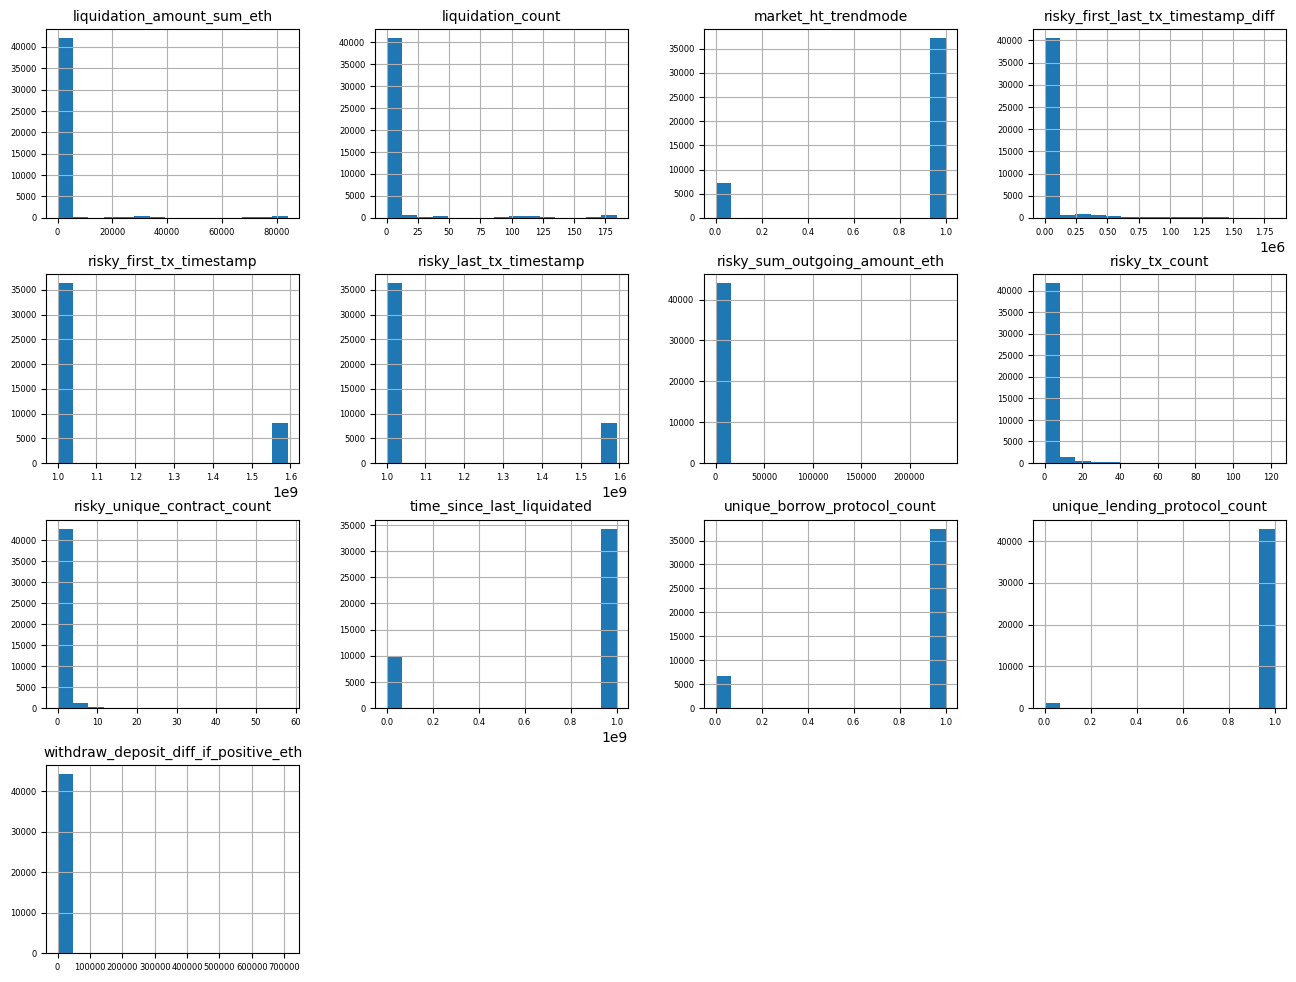

In [319]:
pd.set_option("display.max_columns", maxcols)
# Histogramas para revisar el comportamiento de las variable
axes = X_t0[X_t0.drop(columns=weird['not']).columns].hist(figsize=(16,12), bins=15)
for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=10)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

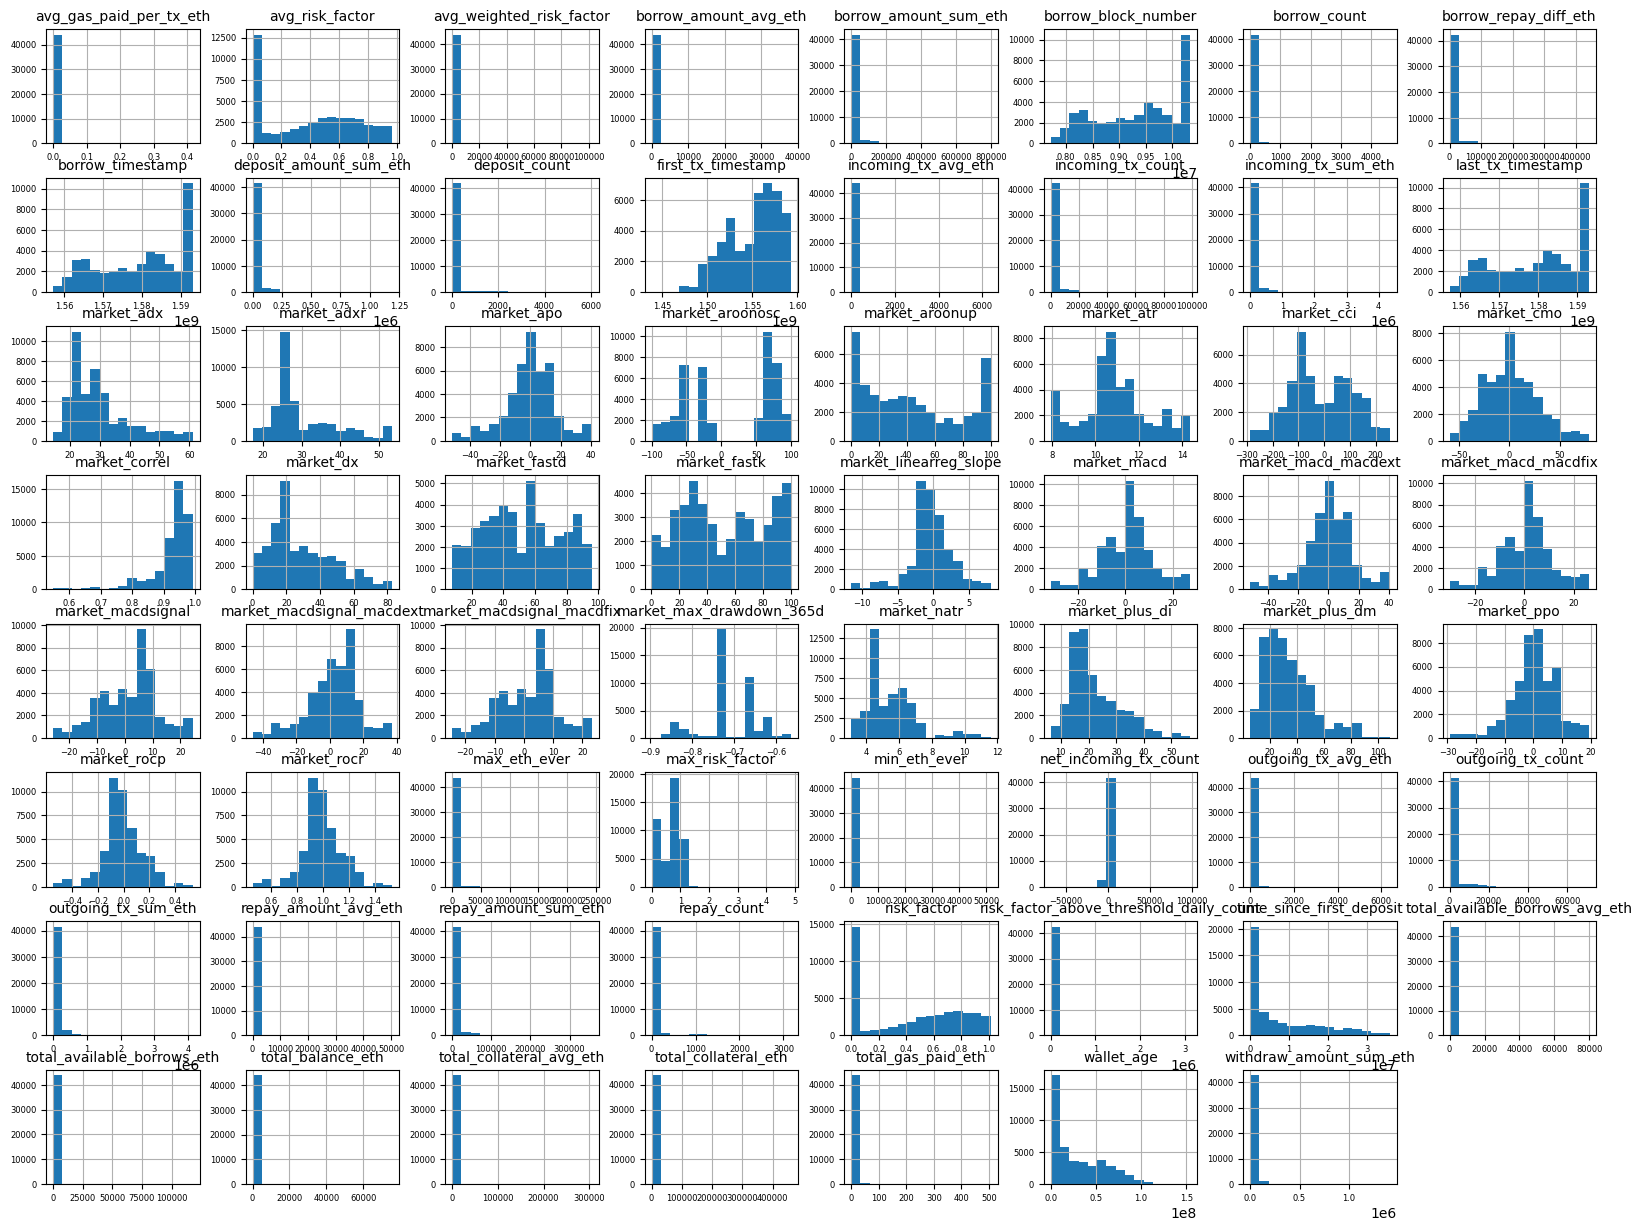

In [320]:
axes = X_t0[weird['not']].hist(figsize=(20,15), bins=15)
for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=10)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

In [321]:
X_corr = X_t0[weird['not']].corr().stack()
X_corr = X_corr[X_corr.index.get_level_values(0) != X_corr.index.get_level_values(1)]
X_corr

avg_gas_paid_per_tx_eth  avg_risk_factor            -0.063659
                         avg_weighted_risk_factor    0.021849
                         borrow_amount_avg_eth       0.053022
                         borrow_amount_sum_eth       0.003014
                         borrow_block_number         0.151973
                                                       ...   
withdraw_amount_sum_eth  total_balance_eth           0.071456
                         total_collateral_avg_eth    0.425276
                         total_collateral_eth        0.391980
                         total_gas_paid_eth          0.299858
                         wallet_age                  0.175796
Length: 3906, dtype: float64

In [322]:
X_corr = X_t0[weird['not']].corr()

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = X_corr.columns,
        y = X_corr.index,
        z = np.array(X_corr),
        text=X_corr.values,
        texttemplate='%{text:.2f}'
    )
)
fig.update_layout(title_text='Correlación entre las variables numéricas',
                    height=800, width=1400)
fig.show()

Vamos a eliminar una de una tupla de variables altamente correlacionadas (>0.95). Es bastante propable, observando los nombres de los campos, que variabes con dicha correlación sean una agregación lineal de la otra.